In [1]:
import os, glob, time, datetime
import numpy as np
import imageio
from PIL import Image
from collections import OrderedDict
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import torch
import torch.nn as nn
from torchvision.utils import save_image

from common.dataset import TrainDataProvider
from common.function import init_embedding, interpolated_embedding_lookup
from common.function import Interpolate_encoded_sources
from common.models import Encoder, Decoder, Discriminator, Generator
from common.utils import denorm_image, show_comparison, save_gif
from get_data.package import pickle_interpolation_data

### GPU Option

In [2]:
GPU = torch.cuda.is_available()
GPU

True

### Hyperparameter setting

In [3]:
FONTS_NUM = 25
EMBEDDING_NUM = 100
BATCH_SIZE = 18
IMG_SIZE = 128
EMBEDDING_DIM = 128

from_model_path = './model_checkpoint/'
data_dir = './interpolation/dataset/'
fixed_dir = './fixed_sample/'

### 150epoch trained model

In [4]:
En = Encoder().cuda()
De = Decoder().cuda()
D = Discriminator(category_num=FONTS_NUM).cuda()

In [5]:
restore = ['150-0604-10:42-Encoder.pkl', '150-0604-10:42-Decoder.pkl', '150-0604-10:42-Discriminator.pkl']

encoder_path, decoder_path, discriminator_path = restore
prev_epoch = int(encoder_path.split('-')[0])
En.load_state_dict(torch.load(os.path.join(from_model_path, encoder_path)))
De.load_state_dict(torch.load(os.path.join(from_model_path, decoder_path)))
D.load_state_dict(torch.load(os.path.join(from_model_path, discriminator_path)))
print("%d epoch trained model has restored" % prev_epoch)

150 epoch trained model has restored


### Embeddings

In [6]:
embeddings = torch.load(os.path.join(fixed_dir, 'EMBEDDINGS.pkl'))
embeddings.shape

torch.Size([100, 1, 1, 128])

---

# Save Generated Outputs
- generated될 character를 정해서 dictionary에 담은 후 저장

### `fixed_char_ids` : 원하는 글씨 24글자 정하기

In [7]:
selected_chars = np.array([3755, 11032, 5328, 8, 4245, 8617, 3544, \
                           3059, 5681, 6473, 6748, 10840, 1992, 9416, \
                           10129, 1189, 3519, 193, 7468, 9399, 2499, 7708, 5264, 876])

random_chars = np.random.choice(np.arange(11172), 32)

In [8]:
fixed_char_ids = selected_chars
fixed_char_ids.sort()
fixed_char_ids = torch.tensor(fixed_char_ids)
torch.save(fixed_char_ids, os.path.join(data_dir, 'fixed_char_ids.pkl'))

In [9]:
fixed_char_ids = torch.load(os.path.join(data_dir, 'fixed_char_ids.pkl'))
fixed_char_ids = fixed_char_ids.numpy()
print(len(fixed_char_ids))
fixed_char_ids

24


array([    8,   193,   876,  1189,  1992,  2499,  3059,  3519,  3544,
        3755,  4245,  5264,  5328,  5681,  6473,  6748,  7468,  7708,
        8617,  9399,  9416, 10129, 10840, 11032])

### `font_filter` : 11172글자 전부 있는 폰트로만 18개 선택

In [10]:
except_ = [1, 2, 3, 4, 22, 23, 24]
font_filter = [i for i in range(25)if i not in except_]
print(len(font_filter))
font_filter

18


[0, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21]

### `interpolation_data.obj` : 24개의 글자 각각 18가지 폰트 이미지 모두 저장하기


- 각 폰트(18종류) 당 24글자이므로 : 432개 파일

In [11]:
# from_dir = './get_data/hangul-dataset-11172/'
# save_path = './interpolation/dataset/interpolation_data.obj'

# pickle_interpolation_data(from_dir, save_path, fixed_char_ids, font_filter)

## Load Data 
### 18fonts x 24chars = 432개 data 

In [12]:
data_provider = TrainDataProvider(data_dir, train_name="interpolation_data.obj", val=False)
total_batches = data_provider.compute_total_batch_num(BATCH_SIZE)
print("total batches:", total_batches)

unpickled total 432 examples
train examples -> 432
total batches: 24


### `all_fonts` : font_ids 를 key로 갖는 dictionary

In [13]:
train_batch_iter = data_provider.get_train_iter(BATCH_SIZE, with_charid=True)

results = {i: {j: None for j in fixed_char_ids} for i in font_filter}

for i, batch in enumerate(train_batch_iter):
    font_ids, char_ids, batch_images = batch
    batch_images = batch_images.cuda()
    embedding_ids = font_ids
    
    # target / source images
    real_targets = batch_images[:, 0, :, :].view([BATCH_SIZE, 1, IMG_SIZE, IMG_SIZE])
    real_sources = batch_images[:, 1, :, :].view([BATCH_SIZE, 1, IMG_SIZE, IMG_SIZE])
    
    # generate fake image
    fake_targets, encoded_sources, encode_layers = Generator(real_sources, En, De, embeddings, \
                                                             embedding_ids, GPU=GPU, encode_layers=True)

    # save fake images by filtering with fonts
    for data in zip(font_ids, char_ids, encoded_sources, real_sources, real_targets, fake_targets):
        fontid, charid, encoded, real_S, real_T, fake_T = data
        real_S = real_S.cpu().detach().numpy()
        real_T = real_T.cpu().detach().numpy()
        fake_T = fake_T.cpu().detach().numpy()
        # (0)idx, (1)encoded, (2)layers, (3)real_source, (4)real_target, (5)fake_target 순서대로 저장
        results[fontid][charid] = [encoded, encode_layers, real_S, real_T, fake_T]

In [14]:
results = {i: OrderedDict(sorted(results[i].items(), key=lambda t: t[0])) for i in results.keys()}

In [15]:
results[5].keys()

odict_keys([8, 193, 876, 1189, 1992, 2499, 3059, 3519, 3544, 3755, 4245, 5264, 5328, 5681, 6473, 6748, 7468, 7708, 8617, 9399, 9416, 10129, 10840, 11032])

- sorted 됐다

In [16]:
for fontid in font_filter:
    print('font [%d] 개수:' % fontid, len(results[fontid]))

font [0] 개수: 24
font [5] 개수: 24
font [6] 개수: 24
font [7] 개수: 24
font [8] 개수: 24
font [9] 개수: 24
font [10] 개수: 24
font [11] 개수: 24
font [12] 개수: 24
font [13] 개수: 24
font [14] 개수: 24
font [15] 개수: 24
font [16] 개수: 24
font [17] 개수: 24
font [18] 개수: 24
font [19] 개수: 24
font [20] 개수: 24
font [21] 개수: 24


- 각 폰트에 대해 24개 글자씩 모두 만들어진 것 확인!

## Fake / Real 각자 저장하기

```
results = {
     'font_id': {'charid': [(0)encoded, (1)layers, (2)real_source, (3)real_target, (4)fake_target]}
}
```

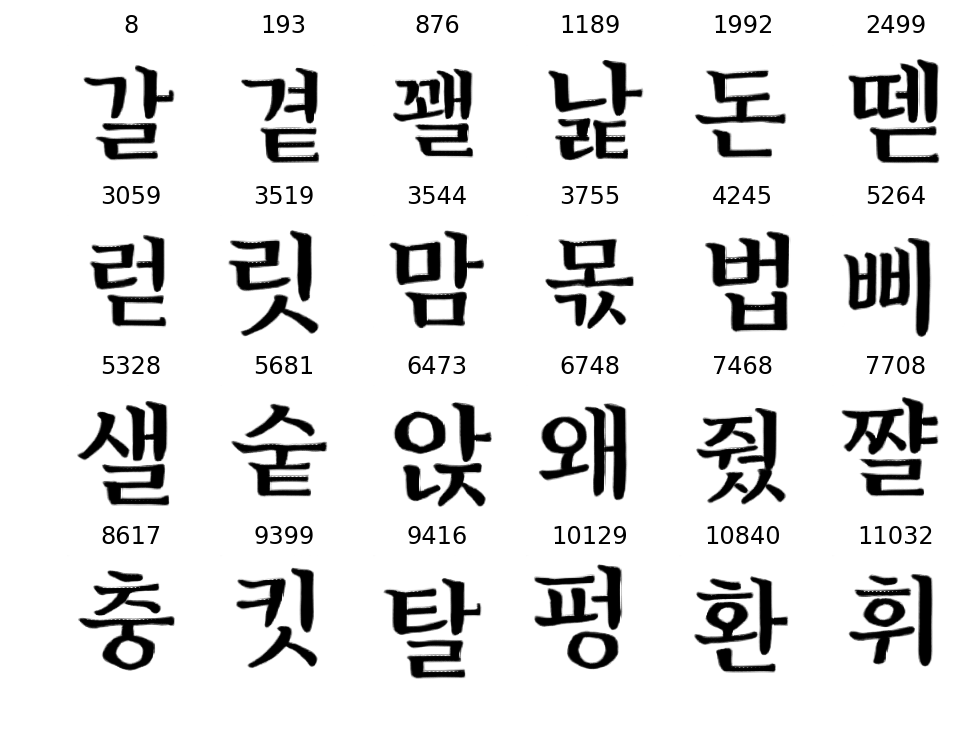

In [17]:
plt.figure(figsize=(8, 6))

for idx, charid in enumerate(fixed_char_ids):
    plt.subplot(4, 6, idx+1)
    plt.imshow(results[0][charid][4].reshape(128, 128), cmap='gray')
    plt.title(charid)
    plt.axis('off')
plt.show()

- 나머지는 image로 save 해두기

### Fake image save

In [18]:
save_path = './output/'
if not os.path.exists(save_path):
    os.mkdir(save_path)

for fontid in font_filter:
    fake_image = torch.tensor(np.array([results[fontid][charid][4] for charid in fixed_char_ids]))
    if len(str(fontid)) == 1:
        fontid = '0' + str(fontid)
    save_image(denorm_image(fake_image.data), \
               os.path.join(save_path, '%s_fake.png' % str(fontid)), \
               nrow=4, pad_value=255)

### Real Target image save

In [19]:
save_path = './output/'
if not os.path.exists(save_path):
    os.mkdir(save_path)

for fontid in font_filter:
    real_image = torch.tensor(np.array([results[fontid][charid][3] for charid in fixed_char_ids]))
    if len(str(fontid)) == 1:
        fontid = '0' + str(fontid)
    save_image(denorm_image(real_image.data), \
               os.path.join(save_path, '%s_real.png' % str(fontid)), \
               nrow=4, pad_value=255)

## Fake + Real 같이 저장하기

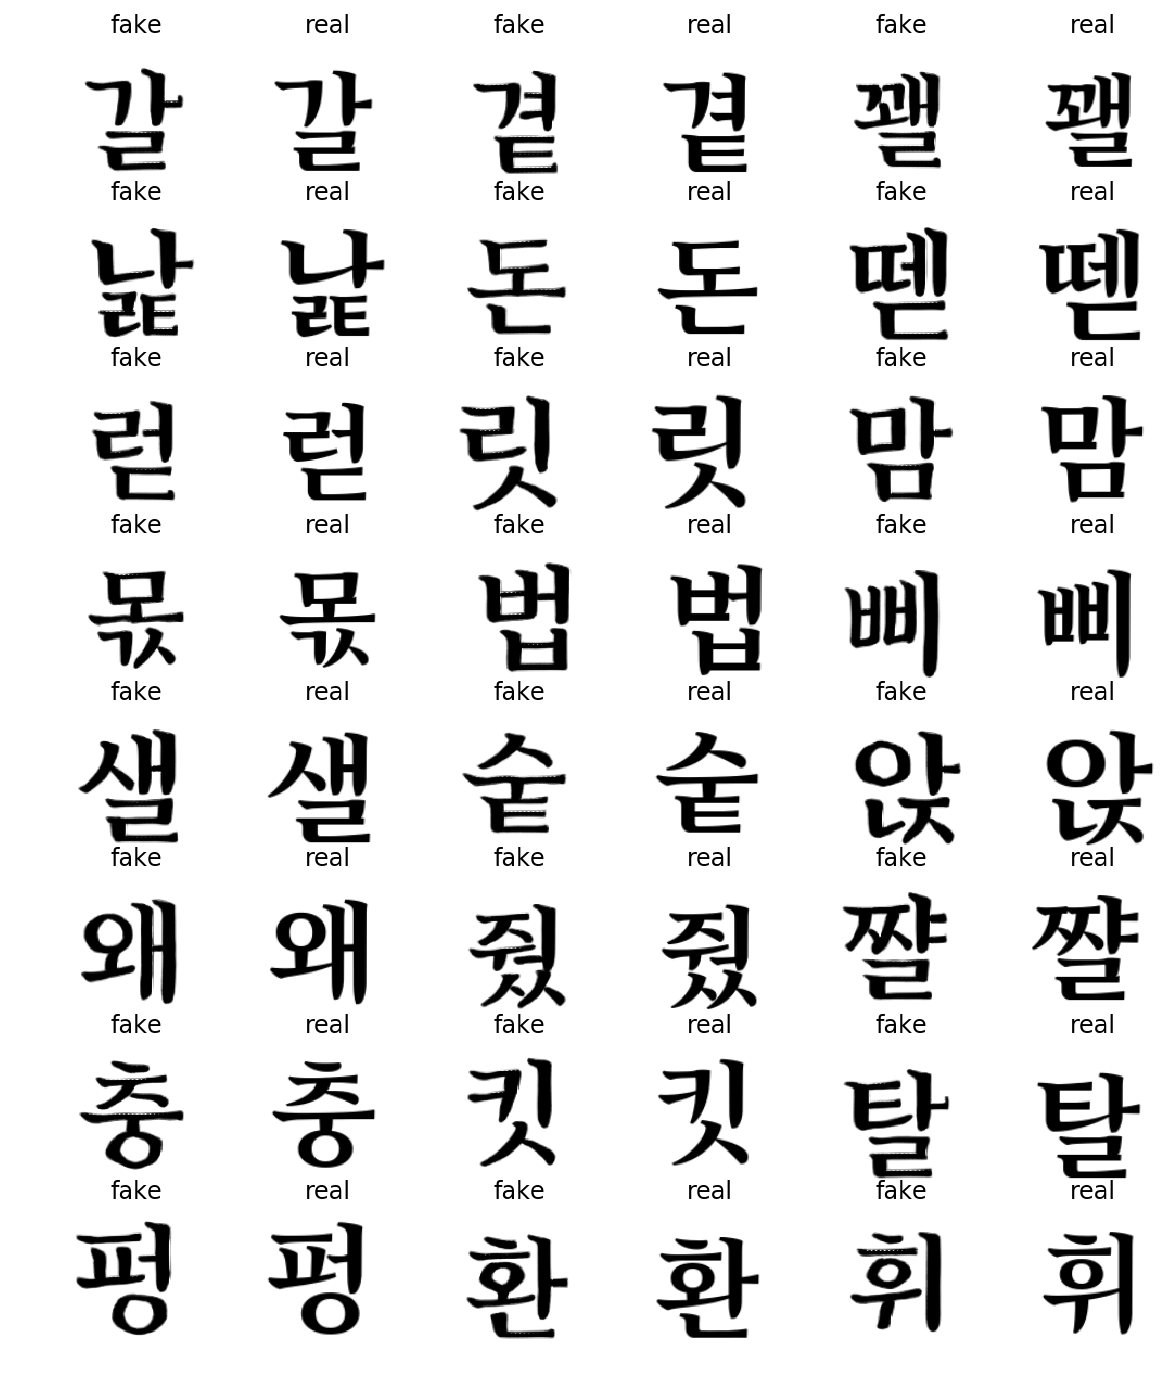

In [20]:
plt.figure(figsize=(10, 12))

for idx, charid in enumerate(fixed_char_ids):
    plt.subplot(8, 6, 2*idx+1)
    plt.imshow(results[0][charid][4].reshape(128, 128), cmap='gray')
    plt.title('fake')
    plt.axis('off')

    plt.subplot(8, 6, 2*idx+2)
    plt.imshow(results[0][charid][3].reshape(128, 128), cmap='gray')
    plt.title('real')
    plt.axis('off')
plt.show()

In [21]:
save_path = './output/'
if not os.path.exists(save_path):
    os.mkdir(save_path)

for fontid in font_filter:
    fake_image = [results[fontid][charid][4] for charid in fixed_char_ids]
    real_image = [results[fontid][charid][3] for charid in fixed_char_ids]
    fake_real_images = np.array([[i, j] for i, j in zip(fake_image, real_image)])
    fake_real_images = torch.tensor(fake_real_images.reshape(48, 1, 128, 128))
    
    if len(str(fontid)) == 1:
        fontid = '0' + str(fontid)
    save_image(denorm_image(fake_real_images.data), \
               os.path.join(save_path, '%s_fake_real.png' % str(fontid)), \
               nrow=6, pad_value=255)